In [68]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

We define our decorator, which makes a folder with the name of the transformation for every transformation, and plots the resulting image

In [69]:
def decorator(fun):
    name=fun.__name__
    par_dir=os.getcwd()
    path=os.path.join(par_dir,name)
    try:
        os.mkdir(path) 
    except OSError as error:
        pass
    def wrapper(inp="inputs/R.jfif", *out_names):

        if out_names==tuple():
            out_names=[name]
        I=cv2.imread(inp)
        rows , cols = I. shape [0:2]
        out= fun(I, cols, rows)
        figi=plt.figure
        figi=plt.subplot(1,len(out)+1,1)
        I_show=cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
        plt.imshow(I_show)
        for i in range(len(out)):
            figi=plt.subplot(1,len(out)+1,i+2)
            I_show=cv2.cvtColor(out[i], cv2.COLOR_BGR2RGB)
            plt.imshow(I_show)
            path_write=os.path.join(path,out_names[i])
    return wrapper

We start with a basic shift

In [70]:
@decorator
def shift(I, cols, rows):
    T = np. float32 ([[1 , 0, 50] , [0, 1, 100]])
    I_shift = cv2. warpAffine (I, T, (cols , rows))
    #I_new=I_shift[100:,50:]
    return [I_shift]

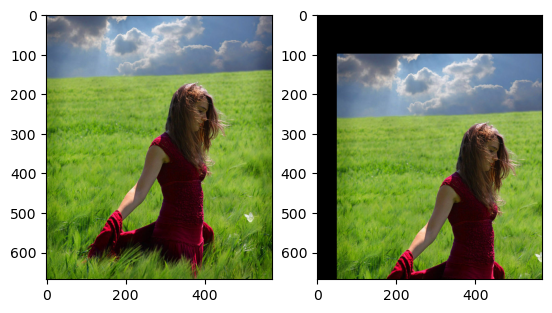

In [71]:
shift()

In [72]:
@decorator
def rotate(I, cols, rows):
    phi = 45.0 * np.pi / 180
    T1 = np.float32(
    [[1, 0, -(cols - 1) / 2.0],
    [0, 1, -(rows - 1) / 2.0],
    [0, 0, 1]])
    T2 = np.float32(
    [[np.cos(phi), -np.sin(phi), 0],
    [np.sin(phi), np.cos(phi), 0],
    [0, 0, 1]])
    T3 = np.float32(
    [[1, 0, (cols - 1) / 2.0],
    [0, 1, (rows - 1) / 2.0],
    [0, 0, 1]])
    T = np.matmul(T3, np.matmul(T2, T1))[0:2, :]
    I_rotate = cv2.warpAffine(I, T, (np.max(I.shape), np.max(I.shape)))
    return [I_rotate]

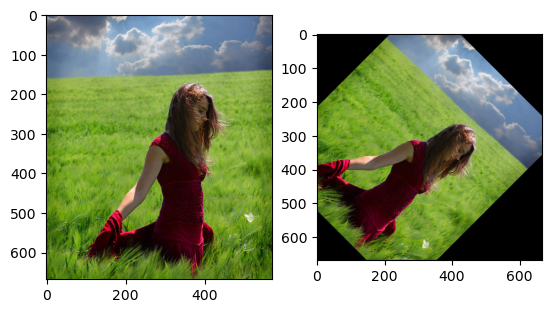

In [73]:
rotate()

In [74]:
@decorator
def stretch(I, cols, rows):
    stch=2
    T = np.float32([[stch, 0, 0], [0, 1, 0]])
    I_piecewiselinear = I.copy()
    I_piecewiselinear[:, int(cols/2):, :] = cv2.warpAffine(I_piecewiselinear[:, int(cols/2):, :], T, (cols - int(cols/2), rows))
    return [I_piecewiselinear]

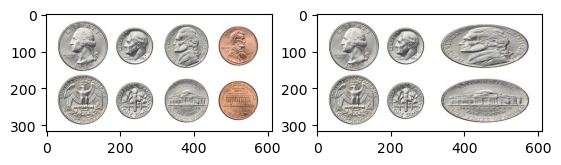

In [75]:
stretch("coins.jpg", "stretched")

In [76]:
@decorator
def projection(I,cols,rows):
    T = np. float32 ([[1.1 , 0.2 , 0.00075] ,[0.35 , 1.1 , 0.0005] ,[0, 0, 1]])
    I_projective = cv2 . warpPerspective (I, T,(cols , rows ))
    return [I_projective]

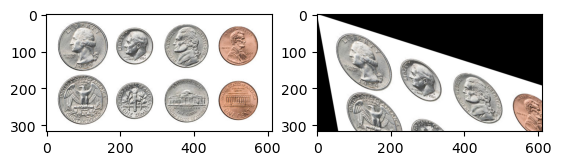

In [77]:
projection("coins.jpg", "proj")

In [78]:
@decorator
def sinusoid(I, cols, rows):
    u, v = np. meshgrid (np. arange ( cols ), np. arange ( rows ))
    u = u + 20 * np.sin (2 * np.pi * v / 90)
    I_sinusoid = cv2 . remap (I, u. astype (np. float32 ), v. astype (np. float32 ), cv2. INTER_LINEAR )
    return [I_sinusoid]

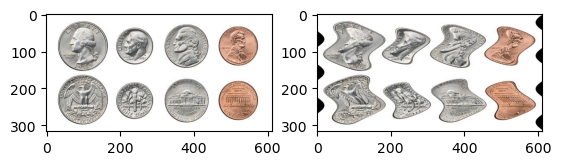

In [79]:
sinusoid("coins.jpg")

In [80]:
@decorator
def barrel(I,cols,rows):
    xi , yi = np. meshgrid (np. arange ( cols ), np. arange ( rows ))
    midx=cols/2
    midy=rows/2
    xi=xi-midx
    yi=yi-midy

    r, theta = cv2.cartToPolar(xi/midx, yi/midy)
    F3 = 0.1
    F5 =0.12
    r = r + F3 * r**3 + F5 * r**5
    u, v = cv2.polarToCart(r, theta)
    u = u * midx + midx
    v = v * midy + midy
    I_barrel = cv2.remap(I, u.astype(np.float32), v.astype(np.float32), cv2.INTER_LINEAR)
    return [I_barrel]

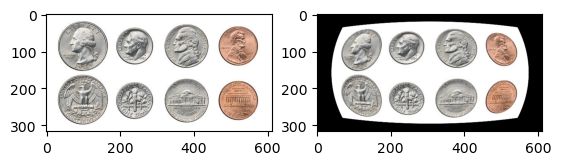

In [81]:
barrel("coins.jpg", "barrel")

In [82]:
@decorator
def poly(I, cols, rows):
    T = np.array([[0, 0], [1, 0], [0, 1], [0.00001, 0], [0.002, 0], [0.001, 0]])
    I_polynomial = np.zeros(I.shape, I.dtype)
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    xnew = np.round(T[0, 0] + x * T[1, 0] + y * T[2, 0] + x * x * T[3, 0] + x * y * T[4, 0] + y * y * T[5, 0]).astype(np.float32)
    ynew = np.round(T[0, 1] + x * T[1, 1] + y * T[2, 1] + x * x * T[3, 1] + x * y * T[4, 1] + y * y * T[5, 1]).astype(np.float32)
    mask = np.logical_and(np.logical_and(xnew >= 0, xnew < cols), np.logical_and(ynew >= 0, ynew < rows))
    if I.ndim == 2:
        I_polynomial[ynew[mask].astype(int), xnew[mask].astype(int)] = I[y[mask], x[mask]]
    else:
        I_polynomial [ ynew [ mask ]. astype (int), xnew [ mask ]. astype (int ), :] =I [y[ mask ], x[ mask ], :]
    return[I_polynomial]

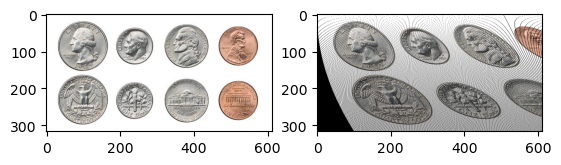

In [83]:
poly("coins.jpg", "poly")

In [84]:
@decorator
def stitching(I, cols, rows):
    I_top=I[:int(rows/2)+100,:,:]

    I_bottom=I[int(rows/2):,:,:]

    templ_size = 10
    templ = I_top[-templ_size:, :, :]
    res = cv2.matchTemplate(I_bottom, templ, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    I_stitch = np.zeros((I_top.shape[0] + I_bottom.shape[0] - max_loc[1] - templ_size, I_top.shape[1], I_top.shape[2]), dtype=np.uint8)
    I_stitch[0:I_top.shape[0], :, :] = I_top
    I_stitch[I_top.shape[0]:, :, :] = I_bottom[max_loc[1] + templ_size:, :, :]
    return [I_top, I_bottom, I_stitch]

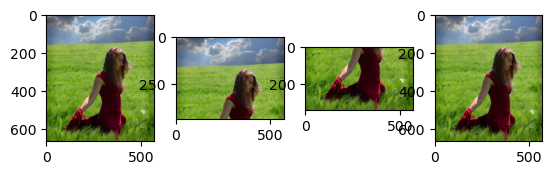

In [85]:
stitching("R.jfif", "top", "bottom", "stitch")